# Make more: MLP deeper (Building a waveNet)

## Recap
- we will continue our implementation of makemore (charachter level language model) 
- Architecture
    - ✔ Bi-gram (one character simply predicts a next one with a lookup table of counts)
    - ✔ MLP (Multi-Layer Perceptron), following [A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf), Bengio et al. 2003
   

- we sticked around the MLP model (lecture 3), studied the activations and gradients (and their distribution), then introduced the BatchNorm and its effect on them (we took some diagnostics to know if the activations and gradients are well distributed, and also to know if the learning is well-adjusted or not)
    - that was lecture 4
- then we studied the backpropagation and implemented it ourselves for that mlp model
    - that was lecture 5

- now we will complexify the mlp, remember that was the mlp architecture we implemented 

![mlp](assets/mlp.png)

we had a single hidden layer with tanh activation,


## New Architecture (WaveNet)

- we would like to take more characters in the context (it was 3)
    - tip: i tried with 4 but end with the same results for the above mlp model
- and we want to add more hidden layers (it was 1)
    - because the single layer squashes too much information too quickly
    - instead we would like a deeper model that progressively fuses this information to make its guess about the next character

- we will see that as we make this architecture more complex, we will arrive at something that looks very much like a WaveNet
    - it was a paper published by DeepMind in 2016, [WaveNet: A Generative Model for Raw Audio](https://arxiv.org/abs/1609.03499), van den Oord et al. 2016, it is also a language model basically, but tries to predict audio sequences instead of text sequences
    - the modeling setup is identical to what we will do
        - it is an autoregressive model, that is, it predicts the next character (or audio sample)
    - it takes this interesting hierarchical approach to predict the next character in the sequence
    ![wavenet](assets/wavenet_approach.png)
    - this is the architecture of the WaveNet
    ![wavenet](assets/wavenet_architecture.png)

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
words = open('makemore/names.txt').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
len(words)

32033

## Vocabulary

In [4]:
# build the vocabulary
vocab = sorted(list(set(''.join(words))))
stoi = { ch: i+1 for i, ch in enumerate(vocab) }
stoi['.'] = 0
itos = { i: ch for ch, i in stoi.items() }
vocab_size = len(stoi)
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [7]:
vocab_size = len(stoi)
vocab_size

27

## Building the dataset

In [8]:
block_size = 3
def build_dataset(words):
    #block_size = 4 # context length: how many characters do we take to predict the next one
    Y, X = [], []
    for word in words:
        #print(word)
        context = ['.'] * block_size  + list(word) + ['.']
        for i in range(len(word) + 1):
            X.append([stoi[ch] for ch in context[i:i+block_size]]) # append at index i, i+1, i+2 (i+3 is the label, that is why it is excluded here)
            Y.append(stoi[context[i+block_size]]) # append the character i+3 as the label
            #print(''.join(context[i:i+block_size]), '->', context[i+block_size])

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
# shuffle the words
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

x_train, y_train = build_dataset(words[:n1])
x_val, y_val = build_dataset(words[n1:n2])
x_test, y_test = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


## The architecture building blocks

In [9]:
class Linear:
    def __init__(self, nin, nout, bias = True):
        self.weight = torch.randn(nin, nout) / (nin**0.5) # multiply with 1/sqrt(nin) to compensate for the weights multiplication
        self.bias = torch.zeros(nout) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([self.bias] if self.bias is not None else []) 

class BatchNorm1d:
    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True # because we will need to know if we are in training or evaluation mode
        # initialize the learnable parameters
        self.gamma = torch.ones(1,dim)
        self.beta = torch.zeros(1,dim)
        # initialize the running mean and var (called Buffers in PyTorch), we used the variance to follow the paper
        self.running_mean = torch.zeros(1,dim)
        self.running_var = torch.ones(1,dim)

    def __call__(self, x):  # shape of x is (m, dim)
        if self.training:
            # use the mean and std of the batch
            mean = x.mean(dim=0, keepdim=True) # mean of the logits over the batch for each neuron, shape (1, dim)
            var = x.var(dim=0, keepdim=True) # std of the logits over the batch for each neuron, shape (1, dim), mine: we might want to add unbiased=True
        else:
            # use the running mean and std
            mean = self.running_mean 
            var = self.running_var
        
        # standardize
        x_standardized = (x - mean) / torch.sqrt(var + self.eps) # shape (m, dim)
        # rescale
        self.out = x_standardized * self.gamma + self.beta # shape (m, dim)

        # update the running mean and std if we are in training mode
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * var

        return self.out # we don't have to save the ouput in .out attribute, but we do so for later visualization

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

- we said that there is a crazy thing about BatchNorm
    - it couples the statistics (therefore the activations) across the examples in the batch
        - normally we thought of the batch as an efficiency thing, but now we are coupling the computation across batch examples (for the purpose of controling the activation statistics and distribution)
    - so it is a very weird layer and might produces a lot of bugs
        - it acts differently during training and evaluation (whether to calculate the statsitics from the batch or use the running statistics)
        - we have to wait for the running statistics to settle and reach a steady state, and use a good momentum depending on the batch_size

In [10]:
torch.manual_seed(42) # seed for reproducibility

## the model (older version)

In [26]:
n_embed = 10 # size of the embedding
n_hidden = 200 # size of the hidden layer

C = torch.randn(vocab_size, n_embed) 

layers = [
    Linear(block_size*n_embed, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

# scale the weights of the layer before softmax (to make it less confident)
with torch.no_grad():
    layers[-1].weight *= 0.1 

# grab all the parameters in a list
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print('Number of parameters:', sum(p.numel() for p in parameters))

# set requires_grad to True for all learnable parameters
for p in parameters:
    p.requires_grad = True

Number of parameters: 12097


In [27]:
steps = 200000
batch_size = 32
lossi = []

for i in range(steps):
    idx = torch.randint(0, x_train.shape[0], (batch_size,))
    # Forward pass
    emb = C[x_train[idx]]
    x = emb.view(-1, block_size * n_embed)
    for layer in layers:
        x = layer(x)

    # Compute loss
    loss = F.cross_entropy(x, y_train[idx])


    ## Visualization purposes: Retain output gradients
    for layer in layers:
        layer.out.retain_grad()

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # step learning rate decay
    lr = 0.1 if i < 100000 else 0.01

    # Update the parameters
    for p in parameters:
        p.data -= p.grad * lr
    
    # track stats
    if i % 10000 == 0:
        print(f"Step {i/steps*100:.2f}%", loss.item())
    lossi.append(loss.log10().item())

Step 0.00% 3.291788101196289
Step 5.00% 2.304138660430908
Step 10.00% 1.9402016401290894
Step 15.00% 2.0366132259368896
Step 20.00% 2.128202438354492
Step 25.00% 2.557307243347168
Step 30.00% 2.5765435695648193
Step 35.00% 2.138232469558716
Step 40.00% 1.9335169792175293
Step 45.00% 2.415210247039795
Step 50.00% 2.2022931575775146
Step 55.00% 2.2526090145111084
Step 60.00% 1.844269871711731
Step 65.00% 2.4020299911499023
Step 70.00% 2.4863967895507812
Step 75.00% 2.1771180629730225
Step 80.00% 1.7876505851745605
Step 85.00% 1.9092751741409302
Step 90.00% 2.2423901557922363
Step 95.00% 2.029301166534424


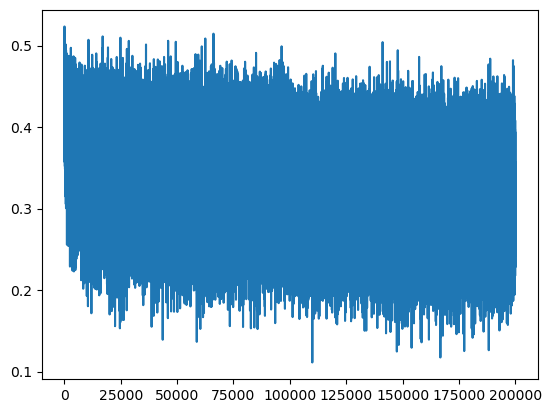

In [28]:
plt.plot(lossi)

- that thickness is because of the small batch_size, (we can get very lucky -down- or unlucky -up- in anyone in these batches), we will fix that soon

In [29]:
@torch.no_grad() # this disables gradient computation, saves memory, and speeds up computation for the following function
def evaluate(split):
    x, y = {
        'train': (x_train, y_train),
        'val': (x_val, y_val),
        'test': (x_test, y_test)
    }[split]
    emb = C[x]
    x = emb.view(-1, block_size * n_embed)
    for layer in layers:
        # set the batch norm to evaluation 
        if isinstance(layer, BatchNorm1d):
            layer.training = False
        x = layer(x)
        # we will need to set the mode back to training after evaluation, in case we will continue training
    loss = F.cross_entropy(x, y)
    print(f"{split} loss: {loss.item()}")

evaluate('train')
evaluate('val')

train loss: 2.063549041748047
val loss: 2.106391668319702


In [31]:
for _ in range(20):
    out = []
    context = [0] * block_size # we start with the '.' index, block_size times
    while True:
        emb = C[torch.tensor(context)] # 1Xblock_size -> 1Xblock_sizeXemb_dim
        x = emb.view(1, -1)
        for layer in layers:
            x = layer(x)
        probs = F.softmax(x, dim=1)
        next_char_idx = torch.multinomial(probs.view(-1), 1).item()
        context = context[1:] + [next_char_idx] # shift the context by one
        out.append(next_char_idx)
        if next_char_idx == 0:
            break

    # print the example now
    print(''.join([itos[i] for i in out]))

zanco.
labim.
cen.
micermar.
adiya.
mylianna.
lokheem.
kinleightin.
sery.
jjt.
oman.
mylan.
grey.
harlea.
evahnaviarathance.
daylee.
karechertlynn.
well.
pankemin.
imin.


## Fix the lossi plot
- mine: the reason for the thickness in the lossi plot, is that it was calculated on different batches of small batch_size, so it is not representative of the loss of the whole dataset
    - so, one thing we can do is to take the average of the losses of the batches for each iteration on the whole dataset

- instead of plotting each batch loss, we will take the mean of each 1000 batches

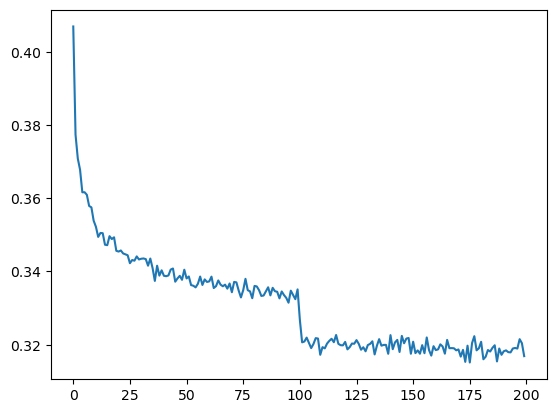

In [59]:
plt.plot(torch.tensor(lossi).reshape(-1,1000).mean(dim=1))

- it is much better now and the reading is for 1000 batches
- we see the decay around 100, which is the learning rate decay (100000/1000 = 100), which around us to settle into sort of local minimum in this optimization

## Pytorchifying all the layers
- we implemented modules for the Linear, Tanh, and BatchNorm layers, but there are still few things we would like to torchify
    - the embedding operation (C lookup table)
    - the flattening operation 

In [152]:
class Embedding:
    def __init__(self,num_embeddings,embedding_dim):
        self.weight = torch.randn((num_embeddings,embedding_dim))

    def __call__(self,x):
        self.out =  self.weight[x]
        return self.out

    def parameters(self):
        return [self.weight]

class Flatten:
    def __call__(self,x,start_dim=1,end_dim=-1):
        # if the end index is negative, convert it to +ve
        if end_dim < 0:
            end_dim += x.dim() 
        
        # shape is whatever before the start_dim as it is, whatever after the end dim as it is, and in between (inside the range) will be -1
        shape = list(x.shape[:start_dim]) + [-1] + list(x.shape[end_dim+1:])
        self.out = x.view(*shape)
        return self.out

    def parameters(self):
        return []


In [157]:
n_embed = 10 # size of the embedding
n_hidden = 200 # size of the hidden layer


layers = [
    Embedding(vocab_size,n_embed),
    Flatten(),
    Linear(block_size*n_embed, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

# scale the weights of the layer before softmax (to make it less confident)
with torch.no_grad():
    layers[-1].weight *= 0.1 

# grab all the parameters in a list
parameters = [p for layer in layers for p in layer.parameters()]
print('Number of parameters:', sum(p.numel() for p in parameters))

# set requires_grad to True for all learnable parameters
for p in parameters:
    p.requires_grad = True

Number of parameters: 12097


In [155]:
steps = 200000
batch_size = 32
lossi = []

for i in range(steps):
    idx = torch.randint(0, x_train.shape[0], (batch_size,))
    # Forward pass
    x = x_train[idx] # get the batch
    for layer in layers:
        x = layer(x)

    # Compute loss
    loss = F.cross_entropy(x, y_train[idx])


    # ## Visualization purposes: Retain output gradients
    # for layer in layers:
    #     layer.out.retain_grad()

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # step learning rate decay
    lr = 0.1 if i < 100000 else 0.01

    # Update the parameters
    for p in parameters:
        p.data -= p.grad * lr
    
    # track stats
    if i % 10000 == 0:
        print(f"Step {i/steps*100:.2f}%", loss.item())
    lossi.append(loss.log10().item())
    break

Step 0.00% 3.298332691192627


## Containers
- in order to further torchify the code, we are maintaining all the modules in a list called layers. Pytorch has a concept called containers (in torch.nn), containers are basically a way of organizing layers into lists or dicts and so on
- one of these containers is called `nn.Sequential`, maintains a list of layers and passes a given input sequentially through them (exactly what we are doing with our layers list)

In [159]:
class Sequential:
    def __init__(self,layers):
        # pass a list of layers
        self.layers = layers

    def __call__(self,x):
        # call the list sequentially
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        # get the parameters of the layers
        return [p for layer in self.layers for p in layer.parameters()]

In [186]:
n_embed = 10 # size of the embedding
n_hidden = 200 # size of the hidden layer
torch.manual_seed(42) # seed for reproducibility

layers = [
    Embedding(vocab_size,n_embed),
    Flatten(),
    Linear(block_size*n_embed, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

model = Sequential(layers)

# scale the weights of the layer before softmax (to make it less confident)
with torch.no_grad():
    model.layers[-1].weight *= 0.1 


print('Number of parameters:', sum(p.numel() for p in model.parameters()))

# set requires_grad to True for all learnable parameters
for p in model.parameters():
    p.requires_grad = True

Number of parameters: 12097


In [188]:
steps = 200000
batch_size = 32
lossi = []

for i in range(steps):
    idx = torch.randint(0, x_train.shape[0], (batch_size,))
    # Forward pass
    x_batch = x_train[idx] # get the batch
    logits = model(x_batch)

    # Compute loss
    loss = F.cross_entropy(logits, y_train[idx])

    # Backward pass
    for p in model.parameters():
        p.grad = None
    loss.backward()

    # step learning rate decay
    lr = 0.1 if i < 100000 else 0.01

    # Update the parameters
    for p in model.parameters():
        p.data -= p.grad * lr
    
    # track stats
    if i % 10000 == 0:
        print(f"Step {i/steps*100:.2f}%", loss.item())
    lossi.append(loss.log10().item())

Step 0.00% 3.2844252586364746
Step 5.00% 2.317671298980713
Step 10.00% 2.419111967086792
Step 15.00% 1.885770559310913
Step 20.00% 1.9076651334762573
Step 25.00% 1.5354812145233154
Step 30.00% 1.6191918849945068
Step 35.00% 2.574326276779175
Step 40.00% 2.083813428878784
Step 45.00% 2.1182568073272705
Step 50.00% 2.2408652305603027
Step 55.00% 2.4125351905822754
Step 60.00% 2.035705327987671
Step 65.00% 1.9049794673919678
Step 70.00% 2.085784912109375
Step 75.00% 1.9257522821426392
Step 80.00% 2.328850269317627
Step 85.00% 1.916623830795288
Step 90.00% 1.7398260831832886
Step 95.00% 1.8464226722717285


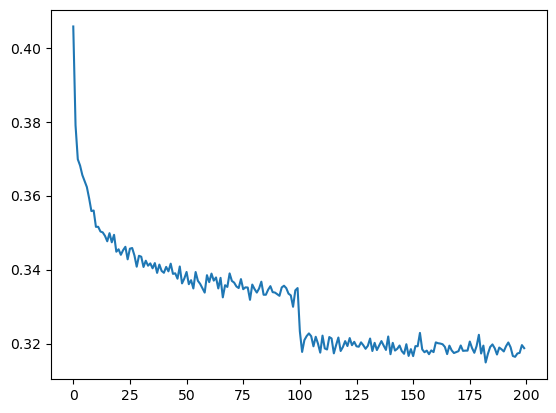

In [189]:
plt.plot(torch.tensor(lossi).reshape(-1,1000).mean(dim=1))

In [190]:
# for the batchNorm inference (we will come up with something better)
for layer in model.layers:
    layer.training = False

@torch.no_grad() # this disables gradient computation, saves memory, and speeds up computation for the following function
def evaluate(split):
    x, y = {
        'train': (x_train, y_train),
        'val': (x_val, y_val),
        'test': (x_test, y_test)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(f"{split} loss: {loss.item()}")

evaluate('train')
evaluate('val')

train loss: 2.062558889389038
val loss: 2.1098880767822266


In [191]:
for _ in range(20):
    out = []
    context = [0] * block_size # we start with the '.' index, block_size times
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        next_char_idx = torch.multinomial(probs.view(-1), 1).item()
        context = context[1:] + [next_char_idx] # shift the context by one
        out.append(next_char_idx)
        if next_char_idx == 0:
            break

    # print the example now
    print(''.join([itos[i] for i in out]))

saylo.
reino.
sophemuellani.
cian.
zaydenthira.
liza.
jah.
grancealynna.
jamaur.
ben.
quan.
torie.
coria.
cer.
tyre.
dia.
beir.
damelays.
kascacolton.
edinicioannie.


## Increasing the context length (lazy upscaling)

In [213]:
block_size = 8
def build_dataset(words):
    #block_size = 4 # context length: how many characters do we take to predict the next one
    Y, X = [], []
    for word in words:
        #print(word)
        context = ['.'] * block_size  + list(word) + ['.']
        for i in range(len(word) + 1):
            X.append([stoi[ch] for ch in context[i:i+block_size]]) # append at index i, i+1, i+2 (i+3 is the label, that is why it is excluded here)
            Y.append(stoi[context[i+block_size]]) # append the character i+3 as the label
            #print(''.join(context[i:i+block_size]), '->', context[i+block_size])

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
# shuffle the words
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

x_train, y_train = build_dataset(words[:n1])
x_val, y_val = build_dataset(words[n1:n2])
x_test, y_test = build_dataset(words[n2:])

torch.Size([182441, 8]) torch.Size([182441])
torch.Size([22902, 8]) torch.Size([22902])
torch.Size([22803, 8]) torch.Size([22803])


In [214]:
n_embed = 10 # size of the embedding
n_hidden = 200 # size of the hidden layer
torch.manual_seed(42) # seed for reproducibility

layers = [
    Embedding(vocab_size,n_embed),
    Flatten(),
    Linear(block_size*n_embed, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

model = Sequential(layers)

# scale the weights of the layer before softmax (to make it less confident)
with torch.no_grad():
    model.layers[-1].weight *= 0.1 


print('Number of parameters:', sum(p.numel() for p in model.parameters()))

# set requires_grad to True for all learnable parameters
for p in model.parameters():
    p.requires_grad = True

Number of parameters: 22097


In [215]:
steps = 200000
batch_size = 32
lossi = []

for i in range(steps):
    idx = torch.randint(0, x_train.shape[0], (batch_size,))
    # Forward pass
    x_batch = x_train[idx] # get the batch
    logits = model(x_batch)

    # Compute loss
    loss = F.cross_entropy(logits, y_train[idx])

    # Backward pass
    for p in model.parameters():
        p.grad = None
    loss.backward()

    # step learning rate decay
    lr = 0.1 if i < 100000 else 0.01

    # Update the parameters
    for p in model.parameters():
        p.data -= p.grad * lr
    
    # track stats
    if i % 10000 == 0:
        print(f"Step {i/steps*100:.2f}%", loss.item())
    lossi.append(loss.log10().item())

Step 0.00% 3.289236307144165
Step 5.00% 2.4962220191955566
Step 10.00% 1.6054571866989136
Step 15.00% 1.881068468093872
Step 20.00% 2.49566388130188
Step 25.00% 2.012378215789795
Step 30.00% 2.4263224601745605
Step 35.00% 2.2539050579071045
Step 40.00% 2.077188730239868
Step 45.00% 2.410477638244629
Step 50.00% 2.0722906589508057
Step 55.00% 2.3579530715942383
Step 60.00% 2.168809652328491
Step 65.00% 2.067152976989746
Step 70.00% 1.9591201543807983
Step 75.00% 2.0796523094177246
Step 80.00% 1.8533257246017456
Step 85.00% 2.4340262413024902
Step 90.00% 1.8900943994522095
Step 95.00% 2.1689038276672363


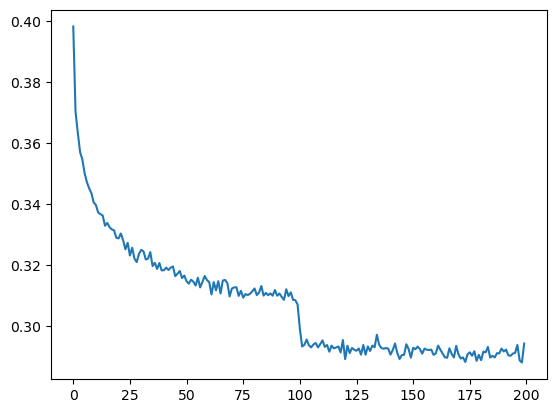

In [216]:
plt.plot(torch.tensor(lossi).reshape(-1,1000).mean(dim=1))

In [217]:
# for the batchNorm inference (we will come up with something better)
for layer in model.layers:
    layer.training = False

@torch.no_grad() # this disables gradient computation, saves memory, and speeds up computation for the following function
def evaluate(split):
    x, y = {
        'train': (x_train, y_train),
        'val': (x_val, y_val),
        'test': (x_test, y_test)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(f"{split} loss: {loss.item()}")

evaluate('train')
evaluate('val')

train loss: 1.929280161857605
val loss: 2.028805732727051


## Complexify the model

- so we got comparable losses on the train and validation set, even though the model parameters were not optimized on the validation set, so we are not overfitting
    - the model is not powerful enough to memorize the training data, and so far we are what's called `underfitting, because the train loss and the dev loss are roughly equal` and we expect to gain perfrmance improvments by scaling up the network, mine: i guess what he means is that as long as both are equal, the model is not powerful enough to overfit the training data, so we expect gain improvments by making the model more powerful therefore reducing the train loss even more (but we stop at a point before it overfits the training data)

- the problem here is, we don't have a naive way (simple way) of making the network bigger in a productive way
    - we may think of stacking more layers, but this will still be ineffective (because the first layer will still be squashing the same too much information too quickly)
    - we may also think of adding more neurons to the hidden layer, but this will also be ineffective (we would still be squashing too much information too quickly into more neurons)

- so, we want our network to look a lot more like WaveNet

![wavenet](assets/wavenet_approach.png)

- notice that each next character is a function of all input neurons (but in a hierarchical way), notice that the inputs are crushed slowly and into multiple layers
    - more precisely, we will take 2 characters and fuse them into a sort of bigram representation, and we do that to all these characters consecutively (each 2 consecutive characters)
    - then we take the bigrams and we fuse them into 4 character level chuncks (mine: like fusing 2 bigrams together, which has a length of 4 characters)
    - then we do that again, and so on in a tree-like hierarchcal way

- this is not what is in the image exactly, but long story short, we fuse the information from the previous context slowly into the network as it gets deeper
    - what is in the image is for the WaveNet case, and it is something called dilated causal convolution layers, which is an implementation detail to make everything fast (later)
    - but the basic idea we should take is the progressive fusion of context 
        - `we want to make the network deeper, and in each level, we want to fuse only 2 consecutive elements in that level`
            - 2 characters 
            - then 2 bigrams
            - then 2 4-grams 
            - and so on

### More on Matrix multiplication
- there is something we talked about in the linear layer in pytorch, that it is applied only to the last dimension of the input tensor
    - that is actually because the matrix multiplication operator in pytorch is powerful 

In [246]:
(torch.randn(32,80) @ torch.randn(80,10)).shape

torch.Size([32, 10])

- this is expected

In [247]:
(torch.randn(4,8,80) @ torch.randn(80,10)).shape

torch.Size([4, 8, 10])

- see that the matrix multiplication is only applied to the last dimension, and it does so for each other dimension in parallel!
    - like the example above, (4,8,80) means that each of the 4x8 elements has an 80-dimensional vector, and we matrix multiply every 4x8 80-d vectors by the 80x10 weights -in parallel- to get a 4x8x10 tensor

- we can use that in our network without having to flatten the input from (batch_size, block_size, n_embed) to (batch_size, block_size * n_embed)
    - we can just keep it as it is and apply matrix multiplication for each example in the batch and for each character in the block size in parallel

- but this actualy allows us to do something more important, this allows us to implement the proposed architecture above
    - instead of previously flattening all 8 blocks for the same example -concatenating them-, we can group each 2 consecutive blocks together and apply the matrix multiplication for each group in parallel

In [257]:
# assuming batch size is 4 and block_size is 8 and n_embed is 10
# previously
(torch.randn(4,8*10) @ torch.randn(8*10,200)).shape

torch.Size([4, 200])

In [259]:
# now we can view the 8 characters as 4 groups of 2 characters (20 embedding dim) now the weights are 20x100
(torch.randn(4,4,20) @ torch.randn(20,100)).shape

torch.Size([4, 4, 100])

- instead of flattening the 8 characters into a single dimension (80), we broke them into group of 2 characters (8 characters total / 2 characters per group = 4 groups) now the dimension is 20 (n_embed * 2), and now the weights got smaller, as they now interact with 2 characters only (for each example in the batch, and for each group of 2 characters in the example) 

In [267]:
dummy = torch.randn(4,8,10)
dummy.reshape(dummy.shape[0],-1,n_embed*2).shape # batch_size,n_groups,dimension of each group
# another way
dummy.reshape(dummy.shape[0],dummy.shape[1]//2,-1).shape
# the most explicit way (because -1 is too flexible)
dummy.reshape(dummy.shape[0],dummy.shape[1]//2,n_embed*2).shape

torch.Size([4, 4, 20])

### New Flatten Implementation (flatten block size characters to groups of n consecutive characters)

In [278]:
class FlattenConsecutive:
    def __init__(self,n_consecutive):
        self.n = n_consecutive
    def __call__(self,x):        
        # shape is whatever before the start_dim as it is, whatever after the end dim as it is, and in between (inside the range) will be -1
        m, chars, emb_dim = x.shape
        x = x.view(m,chars//self.n,emb_dim*self.n)
        # mine: if the number of groups is 1 (like 3 characters with n_consecutive = 2, or 5 characters with n_consecutive = 3)
        if x.shape[1] == 1:
            x = x.squeeze(1) # no need to have that additional dimension
        self.out = x
        return self.out

    def parameters(self):
        return []

In [279]:
FlattenConsecutive(2)(torch.randn(32,8,10)).shape

torch.Size([32, 4, 20])

In [281]:
FlattenConsecutive(3)(torch.randn(32,9,10)).shape

torch.Size([32, 3, 30])

- we made the implementation explicit so that it throws an error when the shapes don't match (can't split the characters into full groups of n_consecutive characters)

In [283]:
FlattenConsecutive(2)(torch.randn(32,5,10)).shape

RuntimeError: shape '[32, 2, 20]' is invalid for input of size 1600

### the new Implementation with FLattenConsecutive

In [317]:
n_embed = 10 # size of the embedding
n_hidden = 68 # size of the hidden layer
torch.manual_seed(42) # seed for reproducibility


layers = [
    Embedding(vocab_size,n_embed),
    FlattenConsecutive(n_consecutive=2), Linear(nin= 2*n_embed,  nout= n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(n_consecutive=2), Linear(nin= 2*n_hidden, nout= n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(n_consecutive=2), Linear(nin= 2*n_hidden, nout= n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

model = Sequential(layers)

# scale the weights of the layer before softmax (to make it less confident)
with torch.no_grad():
    model.layers[-1].weight *= 0.1 


print('Number of parameters:', sum(p.numel() for p in model.parameters()))

# set requires_grad to True for all learnable parameters
for p in model.parameters():
    p.requires_grad = True

Number of parameters: 22397


- we chose the number of hidden units in a way that the total number of parameters is roughly the same as the previous model with 1 layer

- the new model
    - assuming batch_size = 32, block_size = 8, n_embed = 10
    - embedding to get the character embeddings (shape: (32, 8, 10))
    - FlattenConsecutive 2 characters (32, 4, 10*2) -> Linear(weights 20,68) (32, 4, 68) `the linear only changes the last dimension`-> BatchNorm -> Tanh
        - notice that the initial 8 characters were grouped into 4 groups of 2 characters, the linear layer processed each group individually (progressive fusion)
    - FlattenConsecutive 2 bigrams (32, 2, 68 * 2) -> Linear with weights (68 * 2,68) produces (32, 2, 68) -> BatchNorm -> Tanh
        - the 4 groups results were grouped into 2 groups
    - FlattenConsecutive 2 4-grams (32, 1, 68 * 2) -> Linear with weights (68 * 2,68) produces  (32, 1, 68) -> BatchNorm -> Tanh
        - the 2 groups results were grouped into 1 group

- so, notice that the initial number of characters (block size) gets smaller and smaller as we go deeper in the network (gets smaller by a factor of n_consecutive characters)
    - and in each layer we apply the layer to the last dimension (the dimension of each group) while fixing the other dimensions (the batch size and the different groups, it is like they are different examples, they don't interact with each other, that is how we fuse the information progressively)
        - then we take the groups outputs and group them together and so on

- we need to verify that BatchNorm1d will be applied as expected (to the last dimension only such as linear layers)

    

In [318]:
steps = 200000
batch_size = 32
lossi = []

for i in range(steps):
    idx = torch.randint(0, x_train.shape[0], (batch_size,))
    # Forward pass
    x_batch = x_train[idx] # get the batch
    logits = model(x_batch)

    # Compute loss
    loss = F.cross_entropy(logits, y_train[idx])

    # Backward pass
    for p in model.parameters():
        p.grad = None
    loss.backward()

    # step learning rate decay
    lr = 0.1 if i < 100000 else 0.01

    # Update the parameters
    for p in model.parameters():
        p.data -= p.grad * lr
    
    # track stats
    if i % 10000 == 0:
        print(f"Step {i/steps*100:.2f}%", loss.item())
    lossi.append(loss.log10().item())

Step 0.00% 3.302131414413452
Step 5.00% 2.0894088745117188
Step 10.00% 2.0387673377990723
Step 15.00% 2.474092483520508
Step 20.00% 2.0244407653808594
Step 25.00% 1.7274185419082642
Step 30.00% 2.1495466232299805
Step 35.00% 1.869484543800354
Step 40.00% 2.4898393154144287
Step 45.00% 1.7850135564804077
Step 50.00% 1.7460098266601562
Step 55.00% 1.8884193897247314
Step 60.00% 1.7221832275390625
Step 65.00% 1.9079115390777588
Step 70.00% 1.930324673652649
Step 75.00% 1.7516902685165405
Step 80.00% 1.670827031135559
Step 85.00% 2.0142133235931396
Step 90.00% 2.039397954940796
Step 95.00% 2.0784835815429688


In [319]:
for layer in model.layers:
    print(f"{layer.__class__.__name__:20s}", "Shape:", tuple(layer.out.shape))

Embedding            Shape: (32, 8, 10)
FlattenConsecutive   Shape: (32, 4, 20)
Linear               Shape: (32, 4, 68)
BatchNorm1d          Shape: (32, 4, 68)
Tanh                 Shape: (32, 4, 68)
FlattenConsecutive   Shape: (32, 2, 136)
Linear               Shape: (32, 2, 68)
BatchNorm1d          Shape: (32, 2, 68)
Tanh                 Shape: (32, 2, 68)
FlattenConsecutive   Shape: (32, 136)
Linear               Shape: (32, 68)
BatchNorm1d          Shape: (32, 68)
Tanh                 Shape: (32, 68)
Linear               Shape: (32, 27)


In [320]:
# for the batchNorm inference (we will come up with something better)
for layer in model.layers:
    layer.training = False

@torch.no_grad() # this disables gradient computation, saves memory, and speeds up computation for the following function
def evaluate(split):
    x, y = {
        'train': (x_train, y_train),
        'val': (x_val, y_val),
        'test': (x_test, y_test)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(f"{split} loss: {loss.item()}")

evaluate('train')
evaluate('val')

train loss: 1.9522230625152588
val loss: 2.033635377883911


- there are a bunch of hyperparameters that we can search over, in terms how we allocate our budget of parameters to what layers

## Fixing BatchNorm1d bug

- if we analyzed the batch norm, we will see that it receieves a tensor (say of shape (32, 4, 68)), and it calculates the mean and variance, which both will be of shape (1, 4, 68), so, that means we are applying batch norm to each group independently, and the running means and variances will also be calculated for each group independetly
    - so the first neuron in the first group will have a different mean and variance than the first neuron in the second group, and so on
    - but we want to calculate the statistics for each neuron (for all groups and examples)

- we will simply change the mean and variance calculation (they take an argument about the dimension or `dimensions` to reduce), and we will reduce on both the batch size and groups dimension
    - now the mean and variance will be of shape (1, 1, 68), and the running mean and variance will also be of shape (1, 1, 68)
    - and when we apply the normalization, they will be broadcasted for each group and example

In [351]:
class BatchNorm1d:
    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True # because we will need to know if we are in training or evaluation mode
        # initialize the learnable parameters
        self.gamma = torch.ones(1,dim)
        self.beta = torch.zeros(1,dim)
        # initialize the running mean and var (called Buffers in PyTorch), we used the variance to follow the paper
        self.running_mean = torch.zeros(1,dim)
        self.running_var = torch.ones(1,dim)

    def __call__(self, x):  # shape of x is (m, dim)
        if self.training:
            if x.dim() == 2:
                # use the mean and std of the batch
                mean = x.mean(dim=0, keepdim=True) # mean of the logits over the batch for each neuron, shape (1, dim)
                var = x.var(dim=0, keepdim=True) # std of the logits over the batch for each neuron, shape (1, dim), mine: we might want to add unbiased=True
            elif x.dim() == 3:
                # use the mean and std of the batch
                mean = x.mean(dim=(0,1), keepdim=True) # mean of the logits over the batch for each neuron, shape (1, dim)
                var = x.var(dim=(0,1), keepdim=True) # std of the logits over the batch for each neuron, shape (1, dim), mine: we might want to add unbiased=True
        else:
            # use the running mean and std
            mean = self.running_mean 
            var = self.running_var
        
        # standardize
        x_standardized = (x - mean) / torch.sqrt(var + self.eps) # shape (m, dim)
        # rescale
        self.out = x_standardized * self.gamma + self.beta # shape (m, dim)

        # update the running mean and std if we are in training mode
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * var

        return self.out # we don't have to save the ouput in .out attribute, but we do so for later visualization

    def parameters(self):
        return [self.gamma, self.beta]

- we fixed the bug, and renamed the class because it became different from the nn.BatchNorm1d which we mimic
    - in pytorch they either expect a tensor of shape (batch_size, n_features) or (batch_size, n_features, n_time) for the 1d case, but we expect a tensor of shape (batch_size, n_features) or (batch_size, n_time, n_features) for the 1d case

## Train the model with the BatchNorm1d fix

In [357]:
n_embed = 10 # size of the embedding
n_hidden = 68 # size of the hidden layer
torch.manual_seed(42) # seed for reproducibility


layers = [
    Embedding(vocab_size,n_embed),
    FlattenConsecutive(n_consecutive=2), Linear(nin= 2*n_embed,  nout= n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(n_consecutive=2), Linear(nin= 2*n_hidden, nout= n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(n_consecutive=2), Linear(nin= 2*n_hidden, nout= n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

model = Sequential(layers)

# scale the weights of the layer before softmax (to make it less confident)
with torch.no_grad():
    model.layers[-1].weight *= 0.1 


print('Number of parameters:', sum(p.numel() for p in model.parameters()))

# set requires_grad to True for all learnable parameters
for p in model.parameters():
    p.requires_grad = True

Number of parameters: 22397


In [358]:
steps = 200000
batch_size = 32
lossi = []

for i in range(steps):
    idx = torch.randint(0, x_train.shape[0], (batch_size,))
    # Forward pass
    x_batch = x_train[idx] # get the batch
    logits = model(x_batch)

    # Compute loss
    loss = F.cross_entropy(logits, y_train[idx])

    # Backward pass
    for p in model.parameters():
        p.grad = None
    loss.backward()

    # step learning rate decay
    lr = 0.1 if i < 100000 else 0.01

    # Update the parameters
    for p in model.parameters():
        p.data -= p.grad * lr
    
    # track stats
    if i % 10000 == 0:
        print(f"Step {i/steps*100:.2f}%", loss.item())
    lossi.append(loss.log10().item())

Step 0.00% 3.2980918884277344
Step 5.00% 2.076099395751953
Step 10.00% 2.0781426429748535
Step 15.00% 2.44948410987854
Step 20.00% 1.8186713457107544
Step 25.00% 1.7021517753601074
Step 30.00% 2.0998456478118896
Step 35.00% 1.8710083961486816
Step 40.00% 2.4871437549591064
Step 45.00% 1.7470827102661133
Step 50.00% 1.7129472494125366
Step 55.00% 1.8089200258255005
Step 60.00% 1.6254204511642456
Step 65.00% 1.9494229555130005
Step 70.00% 1.876637578010559
Step 75.00% 1.7565984725952148
Step 80.00% 1.5932445526123047
Step 85.00% 1.8931760787963867
Step 90.00% 2.0102460384368896
Step 95.00% 2.190328598022461


In [359]:
# for the batchNorm inference (we will come up with something better)
for layer in model.layers:
    layer.training = False

@torch.no_grad() # this disables gradient computation, saves memory, and speeds up computation for the following function
def evaluate(split):
    x, y = {
        'train': (x_train, y_train),
        'val': (x_val, y_val),
        'test': (x_test, y_test)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(f"{split} loss: {loss.item()}")

evaluate('train')
evaluate('val')

train loss: 1.9232929944992065
val loss: 2.020029067993164


## Scale up the progressive fusion model
- we will use larger embed size and larger hidden size, but using the exact architecture with 3 layers and 2 consecutive characters

In [386]:
n_embed = 24 # size of the embedding
n_hidden = 128 # size of the hidden layer
torch.manual_seed(42) # seed for reproducibility


layers = [
    Embedding(vocab_size,n_embed),
    FlattenConsecutive(n_consecutive=2), Linear(nin= 2*n_embed,  nout= n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(n_consecutive=2), Linear(nin= 2*n_hidden, nout= n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(n_consecutive=2), Linear(nin= 2*n_hidden, nout= n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

model = Sequential(layers)

# scale the weights of the layer before softmax (to make it less confident)
with torch.no_grad():
    model.layers[-1].weight *= 0.1 


print('Number of parameters:', sum(p.numel() for p in model.parameters()))

# set requires_grad to True for all learnable parameters
for p in model.parameters():
    p.requires_grad = True

Number of parameters: 76579


In [363]:
steps = 200000
batch_size = 32
lossi = []

for i in range(steps):
    idx = torch.randint(0, x_train.shape[0], (batch_size,))
    # Forward pass
    x_batch = x_train[idx] # get the batch
    logits = model(x_batch)

    # Compute loss
    loss = F.cross_entropy(logits, y_train[idx])

    # Backward pass
    for p in model.parameters():
        p.grad = None
    loss.backward()

    # step learning rate decay
    lr = 0.1 if i < 100000 else 0.01

    # Update the parameters
    for p in model.parameters():
        p.data -= p.grad * lr
    
    # track stats
    if i % 10000 == 0:
        print(f"Step {i/steps*100:.2f}%", loss.item())
    lossi.append(loss.log10().item())

Step 0.00% 3.309006929397583
Step 5.00% 2.121034860610962
Step 10.00% 2.2164807319641113
Step 15.00% 2.4860150814056396
Step 20.00% 2.149611711502075
Step 25.00% 1.9133975505828857
Step 30.00% 1.7073441743850708
Step 35.00% 1.8024091720581055
Step 40.00% 2.3272483348846436
Step 45.00% 1.7880789041519165
Step 50.00% 1.7864220142364502
Step 55.00% 1.7658624649047852
Step 60.00% 1.697204828262329
Step 65.00% 1.818873643875122
Step 70.00% 1.8990795612335205
Step 75.00% 1.8135185241699219
Step 80.00% 1.6609619855880737
Step 85.00% 2.205733060836792
Step 90.00% 2.021367311477661
Step 95.00% 1.9276087284088135


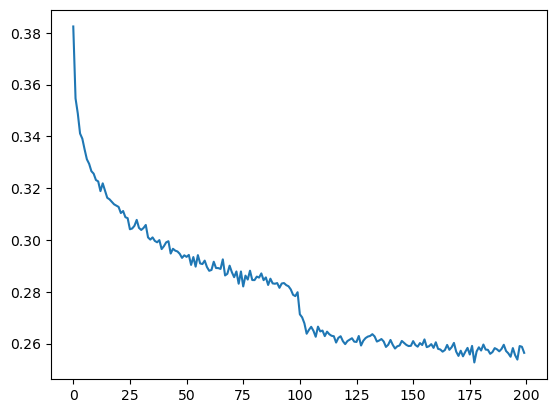

In [369]:
plt.plot(torch.tensor(lossi).reshape(-1,1000).mean(dim=1))

In [364]:
# for the batchNorm inference (we will come up with something better)
for layer in model.layers:
    layer.training = False

@torch.no_grad() # this disables gradient computation, saves memory, and speeds up computation for the following function
def evaluate(split):
    x, y = {
        'train': (x_train, y_train),
        'val': (x_val, y_val),
        'test': (x_test, y_test)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(f"{split} loss: {loss.item()}")

evaluate('train')
evaluate('val')

train loss: 1.7853872776031494
val loss: 1.9854038953781128


- we finally crossed that 2.0 val loss barrier

In [382]:
for _ in range(20):
    out = []
    context = [0] * block_size # we start with the '.' index, block_size times
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        next_char_idx = torch.multinomial(probs.view(-1), 1).item()
        context = context[1:] + [next_char_idx] # shift the context by one
        out.append(next_char_idx)
        if next_char_idx == 0:
            break

    # print the example now
    print(''.join([itos[i] for i in out]))

orsin.
pauls.
hartin.
ved.
jovan.
aasiah.
tracily.
tillian.
rekwal.
contseo.
amiena.
suri.
elisandra.
rayeem.
keemaruch.
rusan.
lexanda.
umrah.
eger.
merdan.


## mine: distribution analysis
- mine: don't forget that it is made at the start of the training (because at the end of the training the network adjusts it to what it likes)

In [418]:
n_embed = 24 # size of the embedding
n_hidden = 128 # size of the hidden layer
torch.manual_seed(42) # seed for reproducibility


layers = [
    Embedding(vocab_size,n_embed),
    FlattenConsecutive(n_consecutive=2), Linear(nin= 2*n_embed,  nout= n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(n_consecutive=2), Linear(nin= 2*n_hidden, nout= n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(n_consecutive=2), Linear(nin= 2*n_hidden, nout= n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

model = Sequential(layers)

# scale the weights of the layer before softmax (to make it less confident)
with torch.no_grad():
    model.layers[-1].weight *= 0.1 


print('Number of parameters:', sum(p.numel() for p in model.parameters()))

# set requires_grad to True for all learnable parameters
for p in model.parameters():
    p.requires_grad = True

Number of parameters: 76579


In [419]:
steps = 200000
batch_size = 32
lossi = []
update_to_weight = []

for i in range(steps):
    idx = torch.randint(0, x_train.shape[0], (batch_size,))
    # Forward pass
    x_batch = x_train[idx] # get the batch
    logits = model(x_batch)

    # Compute loss
    loss = F.cross_entropy(logits, y_train[idx])

    for layer in model.layers:
        layer.out.retain_grad()

    # Backward pass
    for p in model.parameters():
        p.grad = None
    loss.backward()

    # step learning rate decay
    lr = 0.05 if i < 100000 else 0.01

    # Update the parameters
    for p in model.parameters():
        p.data -= p.grad * lr

    with torch.no_grad():
        update_to_weight.append([(p.grad.std() * lr / p.data.std()).log10().item() for p in model.parameters()]) 
    
    # track stats
    if i % 10000 == 0:
        print(f"Step {i/steps*100:.2f}%", loss.item())
    lossi.append(loss.log10().item())

    
    if i > 1000:
        break

Step 0.00% 3.309006929397583


### distribution plots (after a single run)

Layer 4 tanh mean: 0.00, std: 0.62, Saturation: 4.51%
Layer 8 tanh mean: 0.01, std: 0.63, Saturation: 3.88%
Layer 12 tanh mean: -0.00, std: 0.62, Saturation: 3.91%


Text(0.5, 1.0, 'Activations distribution')

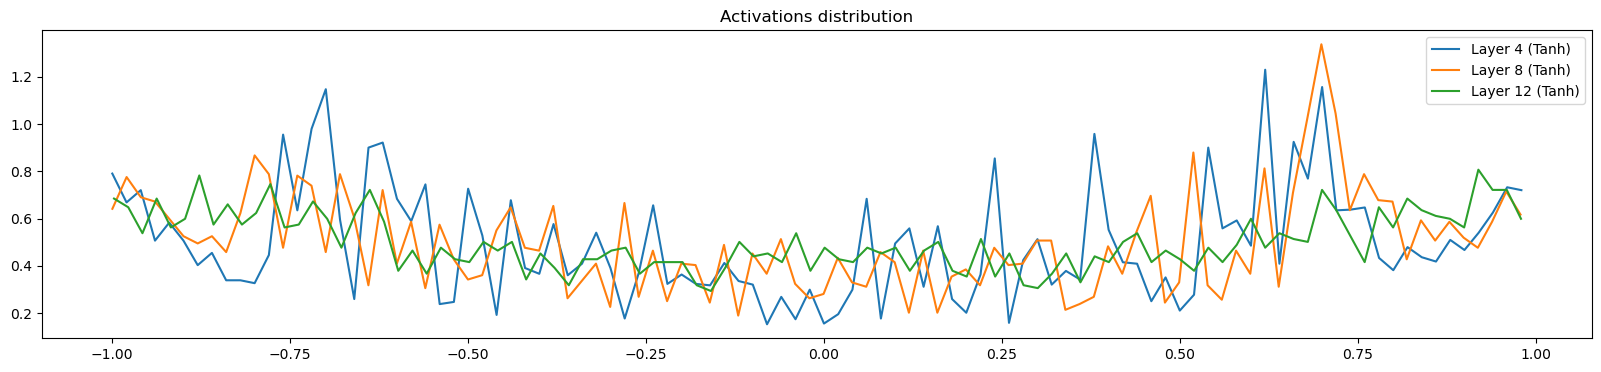

In [410]:
plt.figure(figsize=(20,4))
legends = []

for i, layer in enumerate(model.layers): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out # the output of the tanh
        print(f"Layer {i} tanh mean: {t.mean().item():.2f}, std: {t.std().item():.2f}, Saturation: {(t.abs() > 0.97).float().mean().item()*100:.2f}%")
        hy, hx = torch.histogram(t, density=True) # get the histogram of the tanh output, hx is the bin edges, and hy is the bin values
        plt.plot(hx[:-1].detach(), hy.detach()) 
        legends.append(f"Layer {i} ({layer.__class__.__name__})")

plt.legend(legends)
plt.title("Activations distribution")

Layer 4 tanh mean: -0.00, std: 0.000216
Layer 8 tanh mean: 0.00, std: 0.000235
Layer 12 tanh mean: 0.00, std: 0.000276


Text(0.5, 1.0, 'Gradients distribution')

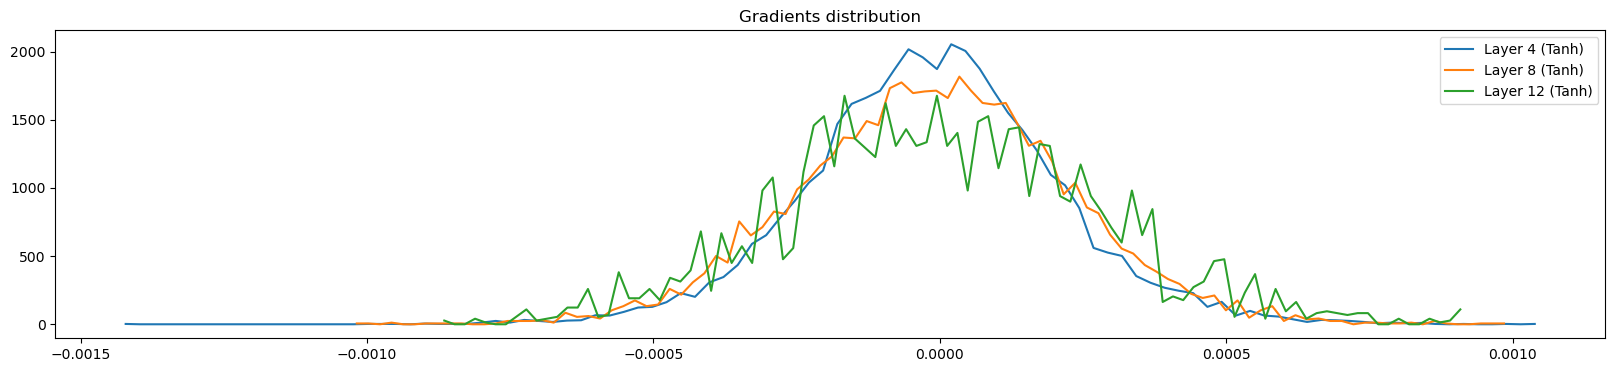

In [411]:
plt.figure(figsize=(20,4))
legends = []

for i, layer in enumerate(model.layers): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad # the output of the tanh
        print(f"Layer {i} tanh mean: {t.mean().item():.2f}, std: {t.std().item():.6f}")
        hy, hx = torch.histogram(t, density=True) # get the histogram of the tanh output, hx is the bin edges, and hy is the bin values
        plt.plot(hx[:-1].detach(), hy.detach()) 
        legends.append(f"Layer {i} ({layer.__class__.__name__})")

plt.legend(legends)
plt.title("Gradients distribution")

## update to weight ratio (after multiple runs)

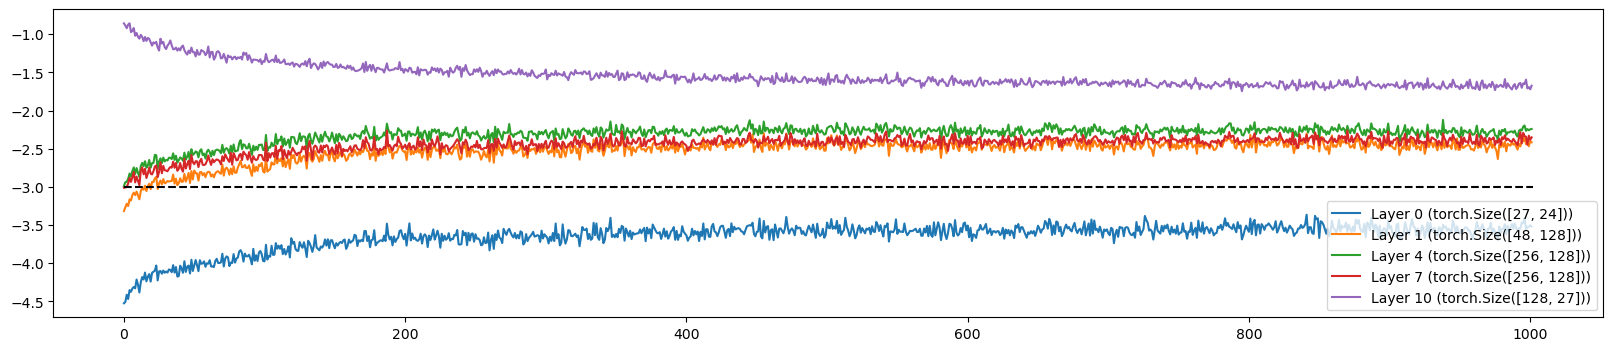

In [420]:
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(model.parameters()):
    if p.squeeze().ndim == 2:
        t = p.grad
        plt.plot([update_to_weight[j][i] for j in range(len(update_to_weight))])
        legends.append(f"Layer {i} ({p.shape})")

plt.plot([0, len(update_to_weight)], [-3, -3], 'k--')
plt.legend(legends)

mine: the update to weight ratio for the Ws is in the good range, and for the final layer is higher (expected because we made it less confident)
- but for the embedding layer it is smaller, why?

## Results log

- original simple model + 3 context length
    - train loss: 2.063549041748047
    - val loss: 2.106391668319702
- original simple model + 8 context length (lazy upscaling)
    - train loss: 1.929280161857605
    - val loss: 2.028805732727051
- progressive fusion model (WaveNet-like) + 8 context length
    - train loss: 1.9522230625152588
    - val loss: 2.033635377883911
    - roughly the same performance (changing from the flat to hierarchical is not giving us anything yet)
- progressive fusion model (WaveNet-like) with the batchnorm fix + 8 context length
    - train loss: 1.9232929944992065
    - val loss: 2.020029067993164
    - a slight boost in performance
- progressive fusion model (WaveNet-like) with larger embed and hidden size + 8 context length
    - train loss: 1.7853872776031494
    - val loss: 1.9854038953781128
    

## Notes

- we are starting to wait longer, and we are a little bit in the dark with respect to the correct setting of the hyperparameters and the learning rates (because the experiments take longer to train)
    - we are missing an experimental harness on which we could run a number of experiments and really tune this architecture very well, we should also look at both the training the validation loss together
        - the whole process is different if we want to tune it
    - we are just guessing and checking which is terrible

- we did implement the hierarchy from the WavNet paper, but we didn't implement their architecture (they have more complicated gated linear layer with residual connections)

- they also use Convulutional operation, which we said is strictly for efficency, it doesn't change the model at all 

In [379]:
for x,y in zip(x_train[13:20],y_train[13:20]):
    print(''.join(itos[xi.item()] for xi in x), '---->', itos[y.item()])

........ ----> m
.......m ----> a
......ma ----> r
.....mar ----> k
....mark ----> u
...marku ----> s
..markus ----> .


- in the colvolution, we just slide a window of a certain context size over the sequences and use them to predict the next character in the  sequence, which is exactly what we did above (we did that manually on the dataset, and expressed the sequence of the name in multiple examples of context size)
- but the convolution is more efficient 

In [380]:
# forward all of the examples of the above name
logits = torch.zeros(7,27)
for i in range(7):
    logits[i] = model(x_train[[13+i]])

- our implementation above is several independent calls to the model, but what convolutions allow us to do is to slide this model efficiently over the input sequences
    - this for loop is not done outside in python as we did, but inside of kernels in cude `in a single pass over the data`
        - the convolution is basically a for loop applying linear filter over a space of some input sequences
    - notice also the variable reuse, when we call the model several times above on slightly convoluted input, we do a lot of recalculation of the same nodes, but in the convolution we re-use it

## Torch.nn

- notice that we have implemented several modules with roughly the same API as the torch.nn
    - so, what we really did over time is implementing torch.nn :), which ist the neural network library on top of torch tensors and auto grad (just like we implemented neural network modules on top of micrograd)
    - so forward we might use them instead since we have a good idea of most of them

## A Glimpse on the development process of deep neural nets

1. notice that we do some things relative to what people do in development
    - we spend a lot of time on the documentation page of Pytorch, reading through the layers, what they do, what are their inputs and their shapes
    - Andrej says pytorch documentation is not very good, it will lie to us, be wrong, incomplete, unclear. So, we just gotta do our best with what they have given us

2. there is a lot of baby sitting of the shapes and functionalities 
    - like are the tensors 2-dimensional, 3-dimensional, what layer take what shapes, and we are permuting and viewing and broadcasting, so we have to babysit all that

3. we very often prototype these layers and implementations in Jupyter Notebooks and babysitting the code step by step, then copy paste that code into the repo of actual code that we train with
    - so we develop in jupyter and paste into the repo, then do the actual training and experimenting their


## What to do next

- make the above code to do convolution instead
- get into more implementation details of the paper
    - like the residual connections and why they are useful
- do actual deep learning workflow to and experiment with the hyperparameters instead of guessing and checking
    - we have to set up our evaluation harness, then kick off experiments and have a lot of arguments that the scrip can take, look at a lot of plots of training and validation losses, and see what is working and what is not working (we work on the population level and do these hyperparameter searches)
        - we did none of that so far
        - so, how to set that up and how to make it good is a whole another topic
- cover RNNs (RNNs, LSTMs, GRUs, Transformers)

- try to beat that loss
    - different ways of allocating the layers (their numbers and neurons)
    - the embedding dimension
    - the consecutive letters 
    - apply more details from the paper
    - tune some of the initialization or optimization